#### last stmt of train and test

In [1]:
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report,confusion_matrix,roc_curve,roc_auc_score, accuracy_score
import matplotlib.pyplot as plt

In [2]:
# Read training data 
df_train_x = pd.read_parquet('D:/Sakshi/DSBA_6156_SERJ/data/train.parquet')
df_train_x.columns = df_train_x.columns.str.lower()
# Read training data labels
df_train_y = pd.read_csv('D:/Sakshi/DSBA_6156_SERJ/data/train_labels.csv')
df_train_y.columns = df_train_y.columns.str.lower()
df_train_y = df_train_y.set_index('customer_id')

df_train_x = df_train_x.sort_values(['customer_id', 's_2'])
df_train = pd.merge(df_train_x, df_train_y, on='customer_id')
del(df_train_x, df_train_y)

In [3]:
df_train['last_statement_flag'] = (df_train.groupby('customer_id')['s_2']
                      .rank(method='dense', ascending=False)
                      .astype(int)
                   )
                 
df_train = df_train[df_train['last_statement_flag']== 1]  
df_train[df_train['customer_id']== '0000f99513770170a1aba690daeeb8a96da4a39f11fc27da5c30a79db61c1e85']\
   [['customer_id','s_2','target','last_statement_flag']]
df_train.drop(columns = 'last_statement_flag', inplace=True)
df_train.reset_index(inplace=True, drop=True)

In [4]:
pipeline = Pipeline(steps=[])
# 89% of d_66 column values were missing, but it has been filled with -1 while parquet generation  
categorical_cols = ['d_63', 'd_64', 'd_66', 'd_68', 'b_30', 'b_31', 'b_38', 'd_114', 'd_116', 'd_117', 'd_120', 'd_126']
df_train[categorical_cols].isnull().sum() / len(df_train)

d_63     0.0
d_64     0.0
d_66     0.0
d_68     0.0
b_30     0.0
b_31     0.0
b_38     0.0
d_114    0.0
d_116    0.0
d_117    0.0
d_120    0.0
d_126    0.0
dtype: float64

In [5]:
class PreProcessing(BaseEstimator, TransformerMixin):
    def __init__(self, categorical_cols):
    
        self.categorical_cols = categorical_cols

    def fit(self, X, y = None):
        # Get the list of columns that have missing values greater than equal to 40%
        missing_perc = round((X.isnull().sum() / len(X)) * 100,2)
        # Prepare final List of columns to drop
        self.cols_to_drop = missing_perc[missing_perc.ge(40)].index.tolist()
 
        return self

    def transform(self, X):
        # Get the clean dataframe with columns to work
        X = X.drop(columns=self.cols_to_drop)

        numeric_cols = list(set(X.columns.tolist(
        )) - set(self.categorical_cols + self.cols_to_drop + ['target', 'customer_id', 's_2']))
        
        for col in numeric_cols:
            # Impute col with mean
            if X[col].isnull().any().any():
                X[col] = X[col].fillna(X[col].mean())

            # Scale
            mean = X[col].mean()
            std = X[col].std()
            if std > 0:
                X[col] = ((X[col] - mean) / std).astype('float32')
        
        # # Apply the transformation defined in pipeline
        # full_transformer = ColumnTransformer(
        #     transformers=[
        #         ("numeric", self.numeric_pipeline, numeric_cols),
        #         ("categorical", self.categorical_pipeline, self.categorical_cols),
        #     ],
        #     # to keep the target column and just passthrough it, instead of dropping
        #     remainder='passthrough'
        # )

        # transformed = full_transformer.fit_transform(df)
        # Converted the array to dataframe
        # df_transformed = pd.DataFrame(data=transformed, columns= numeric_cols +\
        #  self.categorical_cols + ['target']).astype(df.dtypes.to_dict())

        return X

# use all the statements of a customer where all stmts are marked with the same target value
preprocessing = PreProcessing(categorical_cols)
df_processed = preprocessing.fit_transform(df_train)

pipeline.steps.append(('preprocessing', preprocessing))

In [6]:
print(f'The raw dataframe shape : {df_train.shape}')
print(f'The raw dataframe shape : {df_processed.shape}')
del (df_train)

The raw dataframe shape : (458913, 191)
The raw dataframe shape : (458913, 173)


In [7]:
df_corr = pd.read_csv('D:/Sakshi/DSBA_6156_SERJ/ignore/ppt_analysis/corr_laststmt.csv',index_col='Unnamed: 0')
df_vif = pd.read_csv('D:/Sakshi/DSBA_6156_SERJ/ignore/ppt_analysis/vif_laststmt.csv')

In [8]:
rand_state = 2303
class PCATransform(BaseEstimator, TransformerMixin):
    def __init__(self, vif_data):
        self.vif_data = vif_data
        
        # Get the list of the variables with the higher VIF value
        self.vif_variable_lst = vif_data[vif_data['VIF'] >= 10]['feature'].tolist() 

        # List of columns that were considered in pca
        self.pca_cols_to_drop = set()

        self.pca_models = []

    def fit(self, X):
        # Looping on VIF list
        for i in self.vif_variable_lst:   
            # Check if the VIF variable is already in the set from the earlier pass
            bool1 = i in self.pca_cols_to_drop
            # print(bool1)
            if bool1 == True:   
                continue
            else: 
                # Get the list of correlated columns for the current vif column processed
                pca_list = df_corr[(df_corr[i] != 1 ) & ((df_corr[i] >= 0.7) | (df_corr[i] <= -0.7 ))].index.tolist()
                # Perform the below logic, only when any correlated column found
                if len(pca_list) != 0:

                    # Add the processed VIF column also
                    pca_list = [i] + pca_list
                    # print(pca_list)

                    # Append this list to set, as these columns at the later stage needs to be dropped off from the main dataframe, because then the PCA values will be used instead of original column
                    self.pca_cols_to_drop.update(pca_list)
                    
                    # Create the dataframe of only those columns that are correlated with the column processed in the loop
                    df_pca = X.loc[:,pca_list]
                    # Create instance of PCA model
                    pca = PCA(random_state=rand_state)
                    pca.fit_transform(df_pca)

                    # Create eigen value array
                    eigen_arr = pca.explained_variance_
                    # Create a filter array where the eigen value should be >= 1
                    filter_arr = eigen_arr >=1
                    # No. of components with eigen value >= 1
                    no_of_components = len(eigen_arr[filter_arr])
                    
                    # Run the PCA again with the no_of_components found
                    pca = PCA(n_components = no_of_components, random_state=rand_state)
                    pca.fit(df_pca)
                    # append the tuple of the columns went for PCA , no. of components, and the instance of the fitted PCA
                    self.pca_models.append((pca_list, no_of_components, pca))

                    
        return self

    def transform(self, X):
        for pca_list, no_of_components, pca in self.pca_models:
            df_pca = X.loc[:,pca_list]
            PCA_values = pca.transform(df_pca)

            # The number of columns to create for the final PCA dataframe
            pca_columns = []
            for val in range(1, no_of_components + 1):
                a = pca_list[0] + '_pca_' + str(val)
                pca_columns += [a]
                    
            # Create the final PCA dataframe that will be concatenated to original dataframe
            finalpca_df = pd.DataFrame(data = PCA_values, columns=pca_columns)

            # Append this dataframe to main one
            X = pd.concat([X, finalpca_df], axis=1)   

            # Clean-up RAM & memory
            del [[df_pca, finalpca_df]]

        
        # Now remove the columns for which pca was done
        X.drop(columns=self.pca_cols_to_drop, inplace=True)

        return X


pca_transform = PCATransform(df_vif)
df_pca = pca_transform.fit_transform(df_processed)

pipeline.steps.append(('pca', pca_transform))

In [9]:
# Free memory
del(df_processed)

In [10]:
print(f'the shape of dataframe after pca {df_pca.shape}')

the shape of dataframe after pca (458913, 143)


In [11]:
#Logistic Regression model
X = df_pca.drop(columns=['customer_id','s_2','target'])
y = df_pca['target']
# Split the data using stratify method, to avoid only one class data seep in train
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=rand_state,stratify = y)

# Model
sm_logit1 = sm.Logit(y_train,X_train).fit()
print(sm_logit1.summary())

Optimization terminated successfully.
         Current function value: 0.237377
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:                 target   No. Observations:               367130
Model:                          Logit   Df Residuals:                   366990
Method:                           MLE   Df Model:                          139
Date:                Tue, 13 Dec 2022   Pseudo R-squ.:                  0.5850
Time:                        23:55:40   Log-Likelihood:                -87148.
converged:                       True   LL-Null:                   -2.0998e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
p_2            -0.8991      0.015    -60.051      0.000      -0.928      -0.870
d_39            0.3342    

In [12]:
# Remove the insignificant features and train the model again. I will keep the alpha level as 0.05
logit_pvalues = round(sm_logit1.pvalues,3)
high_pval_col = logit_pvalues.index[logit_pvalues > 0.05]

# Drop these columns
X = X.drop(columns = high_pval_col)
print(f'The columns remaining after removing insignificant ones : {X.shape}')
X_train, X_test,y_train, y_test= train_test_split(X, y, test_size=0.2,
                                                     random_state=2303, stratify = y)

# Model
sm_logit2 = sm.Logit(y_train,X_train).fit()
print(sm_logit2.summary())

The columns remaining after removing insignificant ones : (458913, 93)
Optimization terminated successfully.
         Current function value: 0.237461
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:                 target   No. Observations:               367130
Model:                          Logit   Df Residuals:                   367037
Method:                           MLE   Df Model:                           92
Date:                Tue, 13 Dec 2022   Pseudo R-squ.:                  0.5848
Time:                        23:55:49   Log-Likelihood:                -87179.
converged:                       True   LL-Null:                   -2.0998e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
p_2            -0.9034      0.013  

In [13]:
# Calculate the confusion matrix
prediction_probab = sm_logit2.predict(X_test)
prediction = list(map(round,prediction_probab))
confusion_matrix(y_test,prediction)

array([[63727,  4290],
       [ 5315, 18451]], dtype=int64)

Validation accuracy is: 0.8953509909242452
Logistic : ROC AUC = 0.955


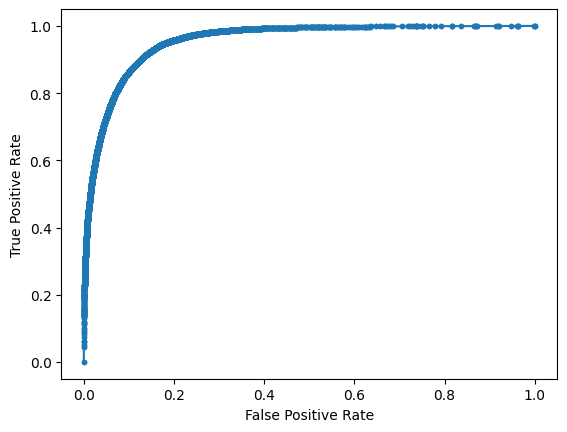

In [14]:
print(f'Validation accuracy is: {accuracy_score(y_test, prediction)}')

# Calculate roc metric 
print('Logistic : ROC AUC = %.3f' % (roc_auc_score(y_test,prediction_probab)))

fpr,tpr,_ = roc_curve(y_test,prediction_probab)
plt.plot(fpr,tpr,marker = '.')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

In [15]:
# Calculate Recall and Precision
print(classification_report(y_test, prediction))

              precision    recall  f1-score   support

           0       0.92      0.94      0.93     68017
           1       0.81      0.78      0.79     23766

    accuracy                           0.90     91783
   macro avg       0.87      0.86      0.86     91783
weighted avg       0.89      0.90      0.89     91783



In [16]:
# Clear the memory before loading the test data to predict
del(fpr,tpr,X_test,X_train,y_test,y_train,X,y,prediction,prediction_probab)

In [17]:
def execute_model(df):
    # Just add extra columns with 0 value so that pipeline does not fail --> these are the extra columns that we had in the training data
    extra_cols = ['target']
    # Concatenate the dataframe of extra columns with the dataframe of the test data
    df = pd.concat([
        df,
        pd.DataFrame(np.zeros((df.shape[0], len(extra_cols))), columns=extra_cols)
    ], axis=1)

    # Use the pipeline to transform
    X = pipeline.transform(df)

    # Drop target & the insignificant variables found during the training using statsmodel p-value
    X.drop(columns=['target','customer_id','s_2'] \
                    + high_pval_col.tolist() , inplace=True)

    # return log_reg.predict_proba(X)
    # In the statsmodel predict will give the probability
    return sm_logit2.predict(X).tolist()
    

In [18]:
del(sm_logit1)
df_test = pd.read_parquet('D:/Sakshi/DSBA_6156_SERJ/data/test.parquet')
df_test.columns= df_test.columns.str.lower()
df_test['last_statement_flag'] = (df_test.groupby('customer_id')['s_2']
                      .rank(method='dense', ascending=False)
                      .astype(np.int8)
                   )
df_test = df_test[df_test['last_statement_flag']== 1].copy()
df_test = df_test.drop(columns='last_statement_flag').reset_index(drop=True)
# Define the result mdf
mdf = pd.DataFrame(columns=['customer_id', 's_2', 'proba'])
y_proba = execute_model(df_test)

mdf = pd.concat([
    mdf,
    pd.DataFrame({
        'customer_id': df_test['customer_id'].values,
        's_2': df_test['s_2'].values,
        'proba': y_proba
    })
])

In [19]:
mdf['s_2'] = pd.to_datetime(mdf['s_2'])
mdf['s_2'].dtype

dtype('<M8[ns]')

In [20]:
# Get the last statement probability of each of the customer
mdf.rename(columns= {'proba' : 'prediction'},inplace=True)
mdf.to_csv('D:/Sakshi/DSBA_6156_SERJ/ignore/ppt_analysis/logistic_pca_laststmt_upd.csv', index=False)